In [3]:
## Initiializations and inputs

import matplotlib.pyplot as plt
import os
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from skimage.color import label2rgb
from skimage.filters import gaussian
from sklearn.cluster import KMeans

In [4]:
plt.close('all')
clear = lambda: os.system('clear')
clear()
np.random.seed(110)

colors = [[1,0,0],[0,1,0],[0,0,1],[0,0.5,0.5],[0.5,0,0.5]] #List of colours

imgNames = ['water_coins','jump','tiger']#{'balloons', 'mountains', 'nature', 'ocean', 'polarlights'};
segmentCounts = [2,3,4,5] 

iteration_counts = {}  # Initialize a dictionary to store iteration counts

In [ ]:
## define functions required for processing

def normalize(img):
    """ min-max normalization """
    h = img.shape[0]
    w = img.shape[1]
    nc = img.shape[2]
    new_img = np.zeros((h,w,nc),dtype='float')
    for cc in range(nc):
        new_img[:,cc] = (img[:,cc] - img[:,cc].min()) / (img[:,cc].max() - img[:,cc].min())
    return(new_img)

def im2double(im): 
    try:
        info = np.iinfo(im.dtype) # Get the data type of the input image
        return im.astype(np.float) / info.max # Divide all values by the largest possible value in the datatype
    except ValueError:
        print('Image is of type Double-- No conversion required') 
        return im.astype(np.float)


In [11]:
for imgName in imgNames:
    for SegCount in segmentCounts:
        # Initialize iteration count for this combination
        iteration_counts[(imgName, SegCount)] = []

        # Construct the path to the image 
        path = join('Input', imgName + '.png')
       
        img = mpimg.imread(path)
        print('Using Matplotlib Image Library: Image is of datatype ',img.dtype,'and size ',img.shape) 

        
        # Load the image using the Python Imaging Library (Pillow)
        img = Image.open(path)
        img = np.array(img)
         
        # Print information about the loaded image
        print('Using Pillow (Python Imaging Library): Image is of datatype', img.dtype, 'and size', img.shape)


        # Define Parameters
        nSegments = SegCount  # Number of color clusters in image
        nPixels = img.shape[0] * img.shape[1]  # Compute number of image pixels from image dimensions
        maxIterations = 20  # Maximum number of iterations allowed for EM algorithm
        nColors = 3  # Number of color channels (assuming RGB image)

        # Determine the output path for writing images to files
        outputPath = join(''.join(['Output/',str(SegCount), '_segments/', imgName , '/']));
        if not(os.path.exists(outputPath)):
            os.makedirs(outputPath)
        mpimg.imsave(''.join([outputPath,'0.png']),img) #save using Matplotlib image library
        # Vectorizing image for easier loops- done as im(:) in Matlab
        pixels = img
        pixels = np.reshape(pixels, (nPixels, nColors, 1))


        # Initialize  parameters
        pi = 1/nSegments*(np.ones((nSegments, 1),dtype='float'))
        increment = np.random.normal(0,.0001,1)
        for seg_ctr in range(len(pi)):
            if(seg_ctr%2==1):
                pi[seg_ctr] = pi[seg_ctr] + increment
                if pi[seg_ctr] > 1:
                    pi[seg_ctr] = 1
            else:
                pi[seg_ctr] = pi[seg_ctr] - increment
                if pi[seg_ctr] < 0:
                    pi[seg_ctr] = 0

        mu = 1/nSegments*(np.ones((nSegments, nColors),dtype='float'))  #for even start
        #add noise to the initialization (but keep it unit)
        for seg_ctr in range(nSegments):
            if(seg_ctr%2==1):
                increment = np.random.normal(0,.0001,1)
            for col_ctr in range(nColors):
                if(seg_ctr%2==1):
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
                else:
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;             
        #EM-iterations begin here. Start with the initial (pi, mu) guesses
        mu_last_iter = mu;
        pi_last_iter = pi;

        for iteration in range(maxIterations):
            iteration_counts[(imgName, SegCount)].append(iteration)

            """%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
               % -----------------   E-STEP  -----
               %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""
            print(''.join(['Image: ',imgName,' nSegments: ',str(nSegments),' iteration: ',str(iteration+1), ' E-step']))
            Ws = np.ones((nPixels,nSegments),dtype='float')  # temporarily reinitialize all weights to 1, before they are recomputed

            for pix_ctr in range(nPixels):
                logAjVec = np.zeros((nSegments,1),dtype='float')# Calculate Ajs
                for seg_ctr in range(nSegments):
                    x_minus_mu_T  = np.transpose(pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T)
                    x_minus_mu    = ((pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T))
                    logAjVec[seg_ctr] = np.log(pi[seg_ctr]) - .5*(np.dot(x_minus_mu_T,x_minus_mu))

                logAmax = max(logAjVec.tolist()) # Note the max
                
                thirdTerm = 0;# Calculate the third term from the final eqn in the above link
                for seg_ctr in range(nSegments):
                    thirdTerm = thirdTerm + np.exp(logAjVec[seg_ctr]-logAmax)

                for seg_ctr in range(nSegments):
                    logY = logAjVec[seg_ctr] - logAmax - np.log(thirdTerm)
                    Ws[pix_ctr][seg_ctr] = np.exp(logY)

            """%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                % -----------------  M-step  --------------------
               %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""
            
            print(''.join(['Image: ',imgName,' nSegments: ',str(nSegments),' iteration: ',str(iteration+1), ' M-step: Mixture coefficients']))
            mu = np.zeros((nSegments,nColors),dtype='float') # mean color for each segment
            pi = np.zeros((nSegments,1),dtype='float') #mixture coefficients

            for seg_ctr in range(nSegments):
                '''
                denominatorSum = 0;
                for pix_ctr in range(nPixels):
                    mu[seg_ctr] = mu[seg_ctr] + pixels[pix_ctr,:,0]*Ws[pix_ctr,seg_ctr]
                    denominatorSum = denominatorSum + Ws[pix_ctr][seg_ctr]
                '''

                
                denominatorSum = np.sum(Ws[:,seg_ctr])
                a = Ws[:, seg_ctr]
                a_tiled = np.tile(a[:, np.newaxis], (1, pixels.shape[1]))
                mu[seg_ctr] = np.sum(pixels[:, :, 0] * a_tiled, axis=0)

                mu[seg_ctr,:] =  mu[seg_ctr,:]/ denominatorSum;
                pi[seg_ctr] = denominatorSum / nPixels;   


            print(np.transpose(pi))

            muDiffSq = np.sum(np.multiply((mu - mu_last_iter),(mu - mu_last_iter)))
            piDiffSq = np.sum(np.multiply((pi - pi_last_iter),(pi - pi_last_iter)))

            if (muDiffSq < .0000001 and piDiffSq < .0000001): #sign of convergence
                print('Convergence Criteria Met at Iteration: ',iteration, '-- Exiting code')
                break;

            mu_last_iter = mu;
            pi_last_iter = pi;

            # Draw the segmented image
            segpixels = np.array(pixels)
            cluster = 0
            for pix_ctr in range(nPixels):
                cluster = np.where(Ws[pix_ctr,:] == max(Ws[pix_ctr,:]))
                vec     = np.squeeze(np.transpose(mu[cluster,:])) 
                segpixels[pix_ctr,:] =  vec.reshape(vec.shape[0],1)

            segpixels = np.reshape(segpixels,(img.shape[0],img.shape[1],nColors)) 
            segpixels = segpixels.astype(np.uint8) # Convert the data type of segpixels to 8-bit

            segpixels = rgb2gray(segpixels) # Convert to grayscale


            kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))# Fit KMeans clustering model 
            
            seglabels = np.reshape(kmeans.labels_, (img.shape[0], img.shape[1]))# Get the labels assigned by KMeans for each pixel and reshape to the image dimensions

            seglabels = gaussian(np.clip(label2rgb(seglabels,colors= colors), 0,1), sigma = 2)# Convert back to colour and smoothen it using gaussian filter.

            mpimg.imsave(''.join([outputPath,str(iteration+1),'.png']),seglabels) #save the segmented output


Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Imaging Library): Image is of datatype uint8 and size (312, 252, 3)
Image: water_coins nSegments: 2 iteration: 1 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing th

Image: water_coins nSegments: 2 iteration: 1 M-step: Mixture coefficients
[[0.49990443 0.50009557]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 2 iteration: 2 E-step
Image: water_coins nSegments: 2 iteration: 2 M-step: Mixture coefficients
[[0.55378062 0.44621938]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 2 iteration: 3 E-step
Image: water_coins nSegments: 2 iteration: 3 M-step: Mixture coefficients
[[0.55766687 0.44233313]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 2 iteration: 4 E-step
Image: water_coins nSegments: 2 iteration: 4 M-step: Mixture coefficients
[[0.5579737 0.4420263]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 2 iteration: 5 E-step
Image: water_coins nSegments: 2 iteration: 5 M-step: Mixture coefficients
[[0.5580353 0.4419647]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 2 iteration: 6 E-step
Image: water_coins nSegments: 2 iteration: 6 M-step: Mixture coefficients
[[0.55803571 0.44196429]]
Convergence Criteria Met at Iteration:  5 -- Exiting code
Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Imaging Library): Image is of datatype uint8 and size (312, 252, 3)
Image: water_coins nSegments: 3 iteration: 1 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment


Image: water_coins nSegments: 3 iteration: 1 M-step: Mixture coefficients
[[0.33336359 0.33325752 0.33337889]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:142: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))# Fit KMeans clustering model
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 2 E-step
Image: water_coins nSegments: 3 iteration: 2 M-step: Mixture coefficients
[[0.44562628 0.00080893 0.55356479]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 3 E-step
Image: water_coins nSegments: 3 iteration: 3 M-step: Mixture coefficients
[[0.41965529 0.04262729 0.53771743]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 4 E-step
Image: water_coins nSegments: 3 iteration: 4 M-step: Mixture coefficients
[[0.41445147 0.04642597 0.53912256]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 5 E-step
Image: water_coins nSegments: 3 iteration: 5 M-step: Mixture coefficients
[[0.41188854 0.04770371 0.54040775]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 6 E-step
Image: water_coins nSegments: 3 iteration: 6 M-step: Mixture coefficients
[[0.41037109 0.04836924 0.54125966]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 7 E-step
Image: water_coins nSegments: 3 iteration: 7 M-step: Mixture coefficients
[[0.40933733 0.04911043 0.54155224]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 8 E-step
Image: water_coins nSegments: 3 iteration: 8 M-step: Mixture coefficients
[[0.40875446 0.04933674 0.5419088 ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 9 E-step
Image: water_coins nSegments: 3 iteration: 9 M-step: Mixture coefficients
[[0.40823714 0.04966376 0.5420991 ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 10 E-step
Image: water_coins nSegments: 3 iteration: 10 M-step: Mixture coefficients
[[0.4078748  0.04998794 0.54213726]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 11 E-step
Image: water_coins nSegments: 3 iteration: 11 M-step: Mixture coefficients
[[0.40755985 0.05008977 0.54235038]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 12 E-step
Image: water_coins nSegments: 3 iteration: 12 M-step: Mixture coefficients
[[0.40749396 0.04998684 0.54251921]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 13 E-step
Image: water_coins nSegments: 3 iteration: 13 M-step: Mixture coefficients
[[0.40725745 0.05016014 0.54258241]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 14 E-step
Image: water_coins nSegments: 3 iteration: 14 M-step: Mixture coefficients
[[0.40712829 0.05026013 0.54261158]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 15 E-step
Image: water_coins nSegments: 3 iteration: 15 M-step: Mixture coefficients
[[0.40712758 0.05025178 0.54262064]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 3 iteration: 16 E-step
Image: water_coins nSegments: 3 iteration: 16 M-step: Mixture coefficients
[[0.40712756 0.05025164 0.5426208 ]]
Convergence Criteria Met at Iteration:  15 -- Exiting code
Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Imaging Library): Image is of datatype uint8 and size (312, 252, 3)
Image: water_coins nSegments: 4 iteration: 1 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment


Image: water_coins nSegments: 4 iteration: 1 M-step: Mixture coefficients
[[0.25019795 0.24983338 0.25010452 0.24986415]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:142: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))# Fit KMeans clustering model
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 2 E-step
Image: water_coins nSegments: 4 iteration: 2 M-step: Mixture coefficients
[[0.44563154 0.00056892 0.00071553 0.55308402]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 3 E-step
Image: water_coins nSegments: 4 iteration: 3 M-step: Mixture coefficients
[[0.42006333 0.01669908 0.02635021 0.53688738]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 4 E-step
Image: water_coins nSegments: 4 iteration: 4 M-step: Mixture coefficients
[[0.40728565 0.02331399 0.03776892 0.53163145]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 5 E-step
Image: water_coins nSegments: 4 iteration: 5 M-step: Mixture coefficients
[[0.40088849 0.02648996 0.04261484 0.53000671]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 6 E-step
Image: water_coins nSegments: 4 iteration: 6 M-step: Mixture coefficients
[[0.39723121 0.0276684  0.04510186 0.52999854]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 7 E-step
Image: water_coins nSegments: 4 iteration: 7 M-step: Mixture coefficients
[[0.39483119 0.02805439 0.04656401 0.53055042]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 8 E-step
Image: water_coins nSegments: 4 iteration: 8 M-step: Mixture coefficients
[[0.3929975  0.02840378 0.04746631 0.53113241]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 9 E-step
Image: water_coins nSegments: 4 iteration: 9 M-step: Mixture coefficients
[[0.39150559 0.02873109 0.0481316  0.53163171]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 10 E-step
Image: water_coins nSegments: 4 iteration: 10 M-step: Mixture coefficients
[[0.39047273 0.02911663 0.04835965 0.53205099]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 11 E-step
Image: water_coins nSegments: 4 iteration: 11 M-step: Mixture coefficients
[[0.3892835  0.02928182 0.04892875 0.53250593]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 12 E-step
Image: water_coins nSegments: 4 iteration: 12 M-step: Mixture coefficients
[[0.38855345 0.02968941 0.04896095 0.53279619]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 13 E-step
Image: water_coins nSegments: 4 iteration: 13 M-step: Mixture coefficients
[[0.38733841 0.02961312 0.04982069 0.53322778]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 14 E-step
Image: water_coins nSegments: 4 iteration: 14 M-step: Mixture coefficients
[[0.38676688 0.02992692 0.04988132 0.53342487]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 15 E-step
Image: water_coins nSegments: 4 iteration: 15 M-step: Mixture coefficients
[[0.38605913 0.0301799  0.050169   0.53359197]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 16 E-step
Image: water_coins nSegments: 4 iteration: 16 M-step: Mixture coefficients
[[0.38533794 0.03026577 0.05057617 0.53382012]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 17 E-step
Image: water_coins nSegments: 4 iteration: 17 M-step: Mixture coefficients
[[0.38451985 0.0304863  0.05107229 0.53392157]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 18 E-step
Image: water_coins nSegments: 4 iteration: 18 M-step: Mixture coefficients
[[0.38405207 0.03061408 0.05129844 0.53403541]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 19 E-step
Image: water_coins nSegments: 4 iteration: 19 M-step: Mixture coefficients
[[0.38389662 0.03083295 0.0511883  0.53408212]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 4 iteration: 20 E-step
Image: water_coins nSegments: 4 iteration: 20 M-step: Mixture coefficients
[[0.38295188 0.03097412 0.05189263 0.53418137]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
/var/folders/xx/pff6mw9j7vj0

Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Imaging Library): Image is of datatype uint8 and size (312, 252, 3)
Image: water_coins nSegments: 5 iteration: 1 E-step
Image: water_coins nSegments: 5 iteration: 1 M-step: Mixture coefficients
[[0.20004159 0.19993807 0.20003542 0.19994101 0.20004391]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:142: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))# Fit KMeans clustering model
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 2 E-step
Image: water_coins nSegments: 5 iteration: 2 M-step: Mixture coefficients
[[4.45490549e-01 3.17443027e-04 3.78920765e-04 5.80464906e-04
  5.53232622e-01]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 3 E-step
Image: water_coins nSegments: 5 iteration: 3 M-step: Mixture coefficients
[[0.41952138 0.00067924 0.01654904 0.02629154 0.53695879]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 4 E-step
Image: water_coins nSegments: 5 iteration: 4 M-step: Mixture coefficients
[[0.40688692 0.01036493 0.01755162 0.03356501 0.53163152]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 5 E-step
Image: water_coins nSegments: 5 iteration: 5 M-step: Mixture coefficients
[[0.39813825 0.01645975 0.02043253 0.03808917 0.5268803 ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 6 E-step
Image: water_coins nSegments: 5 iteration: 6 M-step: Mixture coefficients
[[0.39149998 0.02019484 0.024606   0.04175815 0.52194103]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 7 E-step
Image: water_coins nSegments: 5 iteration: 7 M-step: Mixture coefficients
[[0.38634534 0.02249232 0.03005721 0.04497152 0.51613361]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 8 E-step
Image: water_coins nSegments: 5 iteration: 8 M-step: Mixture coefficients
[[0.38203573 0.02451845 0.03577604 0.04774729 0.5099225 ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 9 E-step
Image: water_coins nSegments: 5 iteration: 9 M-step: Mixture coefficients
[[0.37847136 0.02599789 0.04376763 0.05021792 0.50154521]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 10 E-step
Image: water_coins nSegments: 5 iteration: 10 M-step: Mixture coefficients
[[0.37522828 0.02731685 0.05343436 0.05270065 0.49131986]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 11 E-step
Image: water_coins nSegments: 5 iteration: 11 M-step: Mixture coefficients
[[0.37241187 0.02842236 0.06556116 0.05503464 0.47856997]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 12 E-step
Image: water_coins nSegments: 5 iteration: 12 M-step: Mixture coefficients
[[0.36997689 0.02936051 0.07918689 0.05717835 0.46429736]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 13 E-step
Image: water_coins nSegments: 5 iteration: 13 M-step: Mixture coefficients
[[0.36854161 0.03018124 0.09523103 0.05833858 0.44770754]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 14 E-step
Image: water_coins nSegments: 5 iteration: 14 M-step: Mixture coefficients
[[0.36777204 0.03059138 0.11225129 0.05905415 0.43033114]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 15 E-step
Image: water_coins nSegments: 5 iteration: 15 M-step: Mixture coefficients
[[0.36756068 0.03106124 0.12737995 0.05931827 0.41467985]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 16 E-step
Image: water_coins nSegments: 5 iteration: 16 M-step: Mixture coefficients
[[0.3675286  0.03125876 0.14052883 0.05963044 0.40105337]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 17 E-step
Image: water_coins nSegments: 5 iteration: 17 M-step: Mixture coefficients
[[0.36763478 0.03124332 0.15286058 0.05981249 0.38844882]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 18 E-step
Image: water_coins nSegments: 5 iteration: 18 M-step: Mixture coefficients
[[0.36774793 0.03133891 0.16176577 0.05990876 0.37923862]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 19 E-step
Image: water_coins nSegments: 5 iteration: 19 M-step: Mixture coefficients
[[0.36786085 0.03143174 0.16862993 0.06004911 0.37202837]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: water_coins nSegments: 5 iteration: 20 E-step
Image: water_coins nSegments: 5 iteration: 20 M-step: Mixture coefficients
[[0.36836373 0.03138661 0.17510585 0.05977671 0.3653671 ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
/var/folders/xx/pff6mw9j7vj0

Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319, 3)
Using Pillow (Python Imaging Library): Image is of datatype uint8 and size (480, 319, 3)
Image: jump nSegments: 2 iteration: 1 E-step
Image: jump nSegments: 2 iteration: 1 M-step: Mixture coefficients
[[0.4999604 0.5000396]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 2 E-step
Image: jump nSegments: 2 iteration: 2 M-step: Mixture coefficients
[[0.62757044 0.37242956]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 3 E-step
Image: jump nSegments: 2 iteration: 3 M-step: Mixture coefficients
[[0.70053433 0.29946567]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 4 E-step
Image: jump nSegments: 2 iteration: 4 M-step: Mixture coefficients
[[0.74649955 0.25350045]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 5 E-step
Image: jump nSegments: 2 iteration: 5 M-step: Mixture coefficients
[[0.77507408 0.22492592]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 6 E-step
Image: jump nSegments: 2 iteration: 6 M-step: Mixture coefficients
[[0.79111189 0.20888811]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 7 E-step
Image: jump nSegments: 2 iteration: 7 M-step: Mixture coefficients
[[0.79941721 0.20058279]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 8 E-step
Image: jump nSegments: 2 iteration: 8 M-step: Mixture coefficients
[[0.80292717 0.19707283]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 9 E-step
Image: jump nSegments: 2 iteration: 9 M-step: Mixture coefficients
[[0.80457719 0.19542281]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 10 E-step
Image: jump nSegments: 2 iteration: 10 M-step: Mixture coefficients
[[0.80530571 0.19469429]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 11 E-step
Image: jump nSegments: 2 iteration: 11 M-step: Mixture coefficients
[[0.80554468 0.19445532]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 12 E-step
Image: jump nSegments: 2 iteration: 12 M-step: Mixture coefficients
[[0.80570642 0.19429358]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 13 E-step
Image: jump nSegments: 2 iteration: 13 M-step: Mixture coefficients
[[0.80578177 0.19421823]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 14 E-step
Image: jump nSegments: 2 iteration: 14 M-step: Mixture coefficients
[[0.80584863 0.19415137]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 15 E-step
Image: jump nSegments: 2 iteration: 15 M-step: Mixture coefficients
[[0.8059303 0.1940697]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 16 E-step
Image: jump nSegments: 2 iteration: 16 M-step: Mixture coefficients
[[0.80606306 0.19393694]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 17 E-step
Image: jump nSegments: 2 iteration: 17 M-step: Mixture coefficients
[[0.80614782 0.19385218]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 18 E-step
Image: jump nSegments: 2 iteration: 18 M-step: Mixture coefficients
[[0.80619921 0.19380079]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 19 E-step
Image: jump nSegments: 2 iteration: 19 M-step: Mixture coefficients
[[0.80621555 0.19378445]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 2 iteration: 20 E-step
Image: jump nSegments: 2 iteration: 20 M-step: Mixture coefficients
[[0.80622012 0.19377988]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
/var/folders/xx/pff6mw9j7vj0

Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319, 3)
Using Pillow (Python Imaging Library): Image is of datatype uint8 and size (480, 319, 3)
Image: jump nSegments: 3 iteration: 1 E-step
Image: jump nSegments: 3 iteration: 1 M-step: Mixture coefficients
[[0.33330174 0.33335537 0.33334289]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:142: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))# Fit KMeans clustering model
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 2 E-step
Image: jump nSegments: 3 iteration: 2 M-step: Mixture coefficients
[[0.00612207 0.62443121 0.36944672]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 3 E-step
Image: jump nSegments: 3 iteration: 3 M-step: Mixture coefficients
[[0.26174142 0.5188146  0.21944398]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 4 E-step
Image: jump nSegments: 3 iteration: 4 M-step: Mixture coefficients
[[0.31116992 0.50832796 0.18050212]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 5 E-step
Image: jump nSegments: 3 iteration: 5 M-step: Mixture coefficients
[[0.30966325 0.51421998 0.17611677]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 6 E-step
Image: jump nSegments: 3 iteration: 6 M-step: Mixture coefficients
[[0.30571472 0.51887502 0.17541026]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 7 E-step
Image: jump nSegments: 3 iteration: 7 M-step: Mixture coefficients
[[0.30332687 0.52150333 0.1751698 ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 8 E-step
Image: jump nSegments: 3 iteration: 8 M-step: Mixture coefficients
[[0.30118321 0.52372752 0.17508927]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 9 E-step
Image: jump nSegments: 3 iteration: 9 M-step: Mixture coefficients
[[0.30052924 0.52444048 0.17503028]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 10 E-step
Image: jump nSegments: 3 iteration: 10 M-step: Mixture coefficients
[[0.30062352 0.52436993 0.17500655]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 11 E-step
Image: jump nSegments: 3 iteration: 11 M-step: Mixture coefficients
[[0.30045658 0.52453689 0.17500653]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 12 E-step
Image: jump nSegments: 3 iteration: 12 M-step: Mixture coefficients
[[0.30022492 0.52476877 0.17500631]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 13 E-step
Image: jump nSegments: 3 iteration: 13 M-step: Mixture coefficients
[[0.30024774 0.52475524 0.17499702]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 14 E-step
Image: jump nSegments: 3 iteration: 14 M-step: Mixture coefficients
[[0.30027253 0.52473851 0.17498896]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 15 E-step
Image: jump nSegments: 3 iteration: 15 M-step: Mixture coefficients
[[0.30028485 0.52472826 0.17498689]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 16 E-step
Image: jump nSegments: 3 iteration: 16 M-step: Mixture coefficients
[[0.30028862 0.52472486 0.17498652]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 17 E-step
Image: jump nSegments: 3 iteration: 17 M-step: Mixture coefficients
[[0.30028947 0.5247241  0.17498643]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 3 iteration: 18 E-step
Image: jump nSegments: 3 iteration: 18 M-step: Mixture coefficients
[[0.30028964 0.52472395 0.17498641]]
Convergence Criteria Met at Iteration:  17 -- Exiting code
Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319, 3)
Using Pillow (Python Imaging Library): Image is of datatype uint8 and size (480, 319, 3)
Image: jump nSegments: 4 iteration: 1 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment


Image: jump nSegments: 4 iteration: 1 M-step: Mixture coefficients
[[0.24989598 0.25010847 0.24993794 0.25005761]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:142: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))# Fit KMeans clustering model
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 2 E-step
Image: jump nSegments: 4 iteration: 2 M-step: Mixture coefficients
[[0.00721125 0.36510601 0.62016597 0.00751678]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 3 E-step
Image: jump nSegments: 4 iteration: 3 M-step: Mixture coefficients
[[0.11064231 0.21700459 0.51514631 0.15720679]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 4 E-step
Image: jump nSegments: 4 iteration: 4 M-step: Mixture coefficients
[[0.20336614 0.17911573 0.43861711 0.17890102]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 5 E-step
Image: jump nSegments: 4 iteration: 5 M-step: Mixture coefficients
[[0.25619204 0.17414465 0.38825931 0.181404  ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 6 E-step
Image: jump nSegments: 4 iteration: 6 M-step: Mixture coefficients
[[0.27942251 0.1731594  0.3613045  0.18611359]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 7 E-step
Image: jump nSegments: 4 iteration: 7 M-step: Mixture coefficients
[[0.29997228 0.17302769 0.33547476 0.19152527]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 8 E-step
Image: jump nSegments: 4 iteration: 8 M-step: Mixture coefficients
[[0.31639587 0.17305256 0.31256787 0.1979837 ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 9 E-step
Image: jump nSegments: 4 iteration: 9 M-step: Mixture coefficients
[[0.32782924 0.17320448 0.29587361 0.20309267]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 10 E-step
Image: jump nSegments: 4 iteration: 10 M-step: Mixture coefficients
[[0.33671246 0.17335426 0.28185532 0.20807796]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 11 E-step
Image: jump nSegments: 4 iteration: 11 M-step: Mixture coefficients
[[0.34921169 0.17349791 0.26515959 0.21213081]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 12 E-step
Image: jump nSegments: 4 iteration: 12 M-step: Mixture coefficients
[[0.37230121 0.17358282 0.23838625 0.21572972]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 13 E-step
Image: jump nSegments: 4 iteration: 13 M-step: Mixture coefficients
[[0.40654505 0.17368272 0.19959332 0.22017891]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 14 E-step
Image: jump nSegments: 4 iteration: 14 M-step: Mixture coefficients
[[0.4551202  0.17377576 0.14482725 0.22627679]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 15 E-step
Image: jump nSegments: 4 iteration: 15 M-step: Mixture coefficients
[[0.46513304 0.1739728  0.12662568 0.23426849]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 16 E-step
Image: jump nSegments: 4 iteration: 16 M-step: Mixture coefficients
[[0.45755279 0.17414447 0.12744936 0.24085339]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 17 E-step
Image: jump nSegments: 4 iteration: 17 M-step: Mixture coefficients
[[0.45351849 0.17430121 0.12788074 0.24429956]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 18 E-step
Image: jump nSegments: 4 iteration: 18 M-step: Mixture coefficients
[[0.4505818  0.17435959 0.12801123 0.24704738]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 19 E-step
Image: jump nSegments: 4 iteration: 19 M-step: Mixture coefficients
[[0.44944586 0.17439271 0.12809201 0.24806942]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 4 iteration: 20 E-step
Image: jump nSegments: 4 iteration: 20 M-step: Mixture coefficients
[[0.44923405 0.17441223 0.12810854 0.24824518]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319, 3)
Using Pillow (Python Imaging Library): Image is of datatype uint8 and size (480, 319, 3)
Image: jump nSegments: 5 iteration: 1 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing th

Image: jump nSegments: 5 iteration: 1 M-step: Mixture coefficients
[[0.20011662 0.19980107 0.20007324 0.19983567 0.2001734 ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:142: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))# Fit KMeans clustering model
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 2 E-step
Image: jump nSegments: 5 iteration: 2 M-step: Mixture coefficients
[[0.06568128 0.00563768 0.00521506 0.30359206 0.61987392]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:142: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))# Fit KMeans clustering model
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 3 E-step
Image: jump nSegments: 5 iteration: 3 M-step: Mixture coefficients
[[0.12997466 0.1131063  0.06078137 0.18341534 0.51272234]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 4 E-step
Image: jump nSegments: 5 iteration: 4 M-step: Mixture coefficients
[[0.10419088 0.17683957 0.11192672 0.17258993 0.4344529 ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 5 E-step
Image: jump nSegments: 5 iteration: 5 M-step: Mixture coefficients
[[0.0817664  0.2213737  0.1522861  0.171625   0.37294879]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 6 E-step
Image: jump nSegments: 5 iteration: 6 M-step: Mixture coefficients
[[0.06460363 0.25048866 0.1809881  0.17164351 0.3322761 ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 7 E-step
Image: jump nSegments: 5 iteration: 7 M-step: Mixture coefficients
[[0.05257756 0.28288252 0.19868085 0.1722244  0.29363467]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 8 E-step
Image: jump nSegments: 5 iteration: 8 M-step: Mixture coefficients
[[0.05582873 0.30305739 0.19997286 0.17280563 0.26833539]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 9 E-step
Image: jump nSegments: 5 iteration: 9 M-step: Mixture coefficients
[[0.05805361 0.31015398 0.20124871 0.17291001 0.25763369]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 10 E-step
Image: jump nSegments: 5 iteration: 10 M-step: Mixture coefficients
[[0.05886508 0.31225339 0.2024292  0.17295618 0.25349616]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 11 E-step
Image: jump nSegments: 5 iteration: 11 M-step: Mixture coefficients
[[0.05900367 0.31360899 0.20327495 0.17297544 0.25113695]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 12 E-step
Image: jump nSegments: 5 iteration: 12 M-step: Mixture coefficients
[[0.05903518 0.31661514 0.20434371 0.17297544 0.24703053]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 13 E-step
Image: jump nSegments: 5 iteration: 13 M-step: Mixture coefficients
[[0.05902048 0.31627155 0.20530535 0.17298195 0.24642066]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 14 E-step
Image: jump nSegments: 5 iteration: 14 M-step: Mixture coefficients
[[0.05902105 0.31716874 0.20536694 0.17298198 0.2454613 ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 15 E-step
Image: jump nSegments: 5 iteration: 15 M-step: Mixture coefficients
[[0.05901437 0.31756167 0.2053684  0.17298198 0.24507359]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 16 E-step
Image: jump nSegments: 5 iteration: 16 M-step: Mixture coefficients
[[0.05901125 0.31757106 0.20536887 0.17298198 0.24506684]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 17 E-step
Image: jump nSegments: 5 iteration: 17 M-step: Mixture coefficients
[[0.05901059 0.31757147 0.20536889 0.17298198 0.24506707]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: jump nSegments: 5 iteration: 18 E-step
Image: jump nSegments: 5 iteration: 18 M-step: Mixture coefficients
[[0.05901045 0.31757148 0.20536889 0.17298198 0.2450672 ]]
Convergence Criteria Met at Iteration:  17 -- Exiting code
Using Matplotlib Image Library: Image is of datatype  float32 and size  (492, 654, 3)
Using Pillow (Python Imaging Library): Image is of datatype uint8 and size (492, 654, 3)
Image: tiger nSegments: 2 iteration: 1 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment


Image: tiger nSegments: 2 iteration: 1 M-step: Mixture coefficients
[[0.50017913 0.49982087]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:142: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))# Fit KMeans clustering model
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 2 E-step
Image: tiger nSegments: 2 iteration: 2 M-step: Mixture coefficients
[[0.3934648 0.6065352]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 2 iteration: 3 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 3 M-step: Mixture coefficients
[[0.31868622 0.68131378]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 2 iteration: 4 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 4 M-step: Mixture coefficients
[[0.28064662 0.71935338]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 2 iteration: 5 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 5 M-step: Mixture coefficients
[[0.26233628 0.73766372]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 2 iteration: 6 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 6 M-step: Mixture coefficients
[[0.25351101 0.74648899]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 7 E-step
Image: tiger nSegments: 2 iteration: 7 M-step: Mixture coefficients
[[0.24943588 0.75056412]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 2 iteration: 8 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 8 M-step: Mixture coefficients
[[0.24760652 0.75239348]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 9 E-step
Image: tiger nSegments: 2 iteration: 9 M-step: Mixture coefficients
[[0.2466939 0.7533061]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 10 E-step
Image: tiger nSegments: 2 iteration: 10 M-step: Mixture coefficients
[[0.2462799 0.7537201]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 11 E-step
Image: tiger nSegments: 2 iteration: 11 M-step: Mixture coefficients
[[0.24609038 0.75390962]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 2 iteration: 12 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 12 M-step: Mixture coefficients
[[0.24600549 0.75399451]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 2 iteration: 13 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 13 M-step: Mixture coefficients
[[0.24596264 0.75403736]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 14 E-step
Image: tiger nSegments: 2 iteration: 14 M-step: Mixture coefficients
[[0.24593746 0.75406254]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 15 E-step
Image: tiger nSegments: 2 iteration: 15 M-step: Mixture coefficients
[[0.24592184 0.75407816]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 16 E-step
Image: tiger nSegments: 2 iteration: 16 M-step: Mixture coefficients
[[0.24591199 0.75408801]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 2 iteration: 17 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 17 M-step: Mixture coefficients
[[0.24590574 0.75409426]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 18 E-step
Image: tiger nSegments: 2 iteration: 18 M-step: Mixture coefficients
[[0.24590179 0.75409821]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 2 iteration: 19 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 19 M-step: Mixture coefficients
[[0.24589928 0.75410072]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 2 iteration: 20 E-step
Image: tiger nSegments: 2 iteration: 20 M-step: Mixture coefficients
[[0.2458977 0.7541023]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Using Matplotlib Image Library: Image is of datatype  float32 and size  (492, 654, 3)
Using Pillow (Python Imaging Library): Image is of datatype uint8 and size (492, 654, 3)
Image: tiger nSegments: 3 iteration: 1 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing th

Image: tiger nSegments: 3 iteration: 1 M-step: Mixture coefficients
[[0.33327679 0.33341707 0.33330615]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:142: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))# Fit KMeans clustering model
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 2 E-step
Image: tiger nSegments: 3 iteration: 2 M-step: Mixture coefficients
[[0.01213258 0.37194701 0.61592041]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 3 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 3 M-step: Mixture coefficients
[[0.29041818 0.24314099 0.46644083]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 4 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 4 M-step: Mixture coefficients
[[0.36202476 0.20598351 0.43199174]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 5 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 5 M-step: Mixture coefficients
[[0.37656513 0.19347875 0.42995611]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 6 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 6 M-step: Mixture coefficients
[[0.37592131 0.18855223 0.43552646]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 7 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 7 M-step: Mixture coefficients
[[0.37276881 0.18594051 0.44129068]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 8 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 8 M-step: Mixture coefficients
[[0.36851072 0.18438859 0.44710069]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 9 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 9 M-step: Mixture coefficients
[[0.3649371  0.18330742 0.45175548]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 10 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 10 M-step: Mixture coefficients
[[0.3620135  0.18255362 0.45543288]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 11 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 11 M-step: Mixture coefficients
[[0.35996975 0.18194067 0.45808958]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 12 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 12 M-step: Mixture coefficients
[[0.3584166  0.18144681 0.46013658]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 13 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 13 M-step: Mixture coefficients
[[0.3572981  0.18109604 0.46160585]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 14 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 14 M-step: Mixture coefficients
[[0.35641703 0.18082271 0.46276026]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 15 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 15 M-step: Mixture coefficients
[[0.35531033 0.18063467 0.464055  ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 16 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 16 M-step: Mixture coefficients
[[0.35448906 0.18044782 0.46506312]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 17 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 17 M-step: Mixture coefficients
[[0.35399743 0.18025599 0.46574658]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 18 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 18 M-step: Mixture coefficients
[[0.35356526 0.18014352 0.46629121]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 19 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 19 M-step: Mixture coefficients
[[0.35300129 0.18007167 0.46692705]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 3 iteration: 20 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 3 iteration: 20 M-step: Mixture coefficients
[[0.35260996 0.17999757 0.46739247]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Using Matplotlib Image Library: Image is of datatype  float32 and size  (492, 654, 3)
Using Pillow (Python Imaging Library): Image is of datatype uint8 and size (492, 654, 3)
Image: tiger nSegments: 4 iteration: 1 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing th

Image: tiger nSegments: 4 iteration: 1 M-step: Mixture coefficients
[[0.24989324 0.25011118 0.24988786 0.25010771]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:142: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))# Fit KMeans clustering model
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 2 E-step
Image: tiger nSegments: 4 iteration: 2 M-step: Mixture coefficients
[[0.58683124 0.34185356 0.03657705 0.03473815]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 3 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 3 M-step: Mixture coefficients
[[0.42582059 0.2218455  0.19944232 0.15289159]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 4 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 4 M-step: Mixture coefficients
[[0.36053257 0.18268693 0.27363064 0.18314985]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 5 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 5 M-step: Mixture coefficients
[[0.32204302 0.16473105 0.32481332 0.18841261]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 6 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 6 M-step: Mixture coefficients
[[0.29873857 0.15547615 0.35847101 0.18731426]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 7 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 7 M-step: Mixture coefficients
[[0.28616086 0.1499412  0.3785982  0.18529974]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 8 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 8 M-step: Mixture coefficients
[[0.27992836 0.14649327 0.390398   0.18318038]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 9 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 9 M-step: Mixture coefficients
[[0.27516864 0.14355316 0.39930933 0.18196887]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 10 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 10 M-step: Mixture coefficients
[[0.27332138 0.14159042 0.40432376 0.18076444]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 11 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 11 M-step: Mixture coefficients
[[0.27309762 0.14038467 0.4074115  0.17910622]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 12 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 12 M-step: Mixture coefficients
[[0.27402184 0.13940864 0.40858747 0.17798206]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 13 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 13 M-step: Mixture coefficients
[[0.27563035 0.13873069 0.40861342 0.17702555]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 14 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 14 M-step: Mixture coefficients
[[0.27918819 0.13828388 0.406567   0.17596094]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 15 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 15 M-step: Mixture coefficients
[[0.28266737 0.13782144 0.40454299 0.1749682 ]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 16 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 16 M-step: Mixture coefficients
[[0.28563441 0.13741891 0.40298884 0.17395784]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 17 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 17 M-step: Mixture coefficients
[[0.28872633 0.13699307 0.40121494 0.17306566]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 18 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 18 M-step: Mixture coefficients
[[0.29120038 0.1366703  0.39997907 0.17215026]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 19 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 19 M-step: Mixture coefficients
[[0.29374021 0.13636454 0.39846432 0.17143092]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 4 iteration: 20 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 4 iteration: 20 M-step: Mixture coefficients
[[0.2959408  0.13606155 0.39718849 0.17080917]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Using Matplotlib Image Library: Image is of datatype  float32 and size  (492, 654, 3)
Using Pillow (Python Imaging Library): Image is of datatype uint8 and size (492, 654, 3)
Image: tiger nSegments: 5 iteration: 1 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing th

Image: tiger nSegments: 5 iteration: 1 M-step: Mixture coefficients
[[0.19991857 0.20013167 0.19991988 0.20011453 0.19991535]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:142: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = SegCount).fit(np.reshape(segpixels,(nPixels, 1)))# Fit KMeans clustering model
/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 2 E-step
Image: tiger nSegments: 5 iteration: 2 M-step: Mixture coefficients
[[0.11404997 0.36338801 0.50322793 0.00913208 0.01020201]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 3 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 3 M-step: Mixture coefficients
[[0.1871001  0.23623897 0.34771844 0.08853351 0.14040897]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 4 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 4 M-step: Mixture coefficients
[[0.23859599 0.18900779 0.27875266 0.12702264 0.16662092]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 5 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 5 M-step: Mixture coefficients
[[0.28908603 0.16645994 0.21305302 0.16925015 0.16215086]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 6 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 6 M-step: Mixture coefficients
[[0.31159726 0.15319767 0.1757015  0.2061387  0.15336488]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 7 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 7 M-step: Mixture coefficients
[[0.32115983 0.14338714 0.15555634 0.23205771 0.14783897]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 8 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 8 M-step: Mixture coefficients
[[0.32735658 0.13680828 0.14222382 0.24938276 0.14422856]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 9 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 9 M-step: Mixture coefficients
[[0.3283209  0.13217387 0.13589727 0.2610347  0.14257326]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 10 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 10 M-step: Mixture coefficients
[[0.32880898 0.12859391 0.13232102 0.26831159 0.14196449]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 11 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 11 M-step: Mixture coefficients
[[0.32934641 0.12635412 0.13019207 0.27313069 0.14097671]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 12 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 12 M-step: Mixture coefficients
[[0.33010332 0.1248247  0.12910734 0.2756919  0.14027274]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 13 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 13 M-step: Mixture coefficients
[[0.33110694 0.12388958 0.12858378 0.27698992 0.13942978]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 14 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 14 M-step: Mixture coefficients
[[0.33218528 0.1230486  0.12838734 0.27729503 0.13908375]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 15 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 15 M-step: Mixture coefficients
[[0.33326944 0.12245536 0.12834097 0.27727552 0.13865871]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 16 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 16 M-step: Mixture coefficients
[[0.33434322 0.1220107  0.12837012 0.27701287 0.13826309]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 17 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 17 M-step: Mixture coefficients
[[0.33549942 0.1217147  0.12845991 0.27643733 0.13788864]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 18 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 18 M-step: Mixture coefficients
[[0.33638315 0.12149892 0.12859509 0.27605385 0.13746898]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 19 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 19 M-step: Mixture coefficients
[[0.33720763 0.12130342 0.128755   0.27560345 0.13713051]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image: tiger nSegments: 5 iteration: 20 E-step


/var/folders/xx/pff6mw9j7vj0zm_pw9v03rnc0000gp/T/ipykernel_99889/2569498712.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ws[pix_ctr][seg_ctr] = np.exp(logY)


Image: tiger nSegments: 5 iteration: 20 M-step: Mixture coefficients
[[0.33792279 0.12112539 0.12894236 0.27515849 0.13685096]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
print(iteration_counts)

{('water_coins', 2): [0, 1, 2, 3, 4, 5], ('water_coins', 3): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ('water_coins', 4): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], ('water_coins', 5): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], ('jump', 2): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], ('jump', 3): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], ('jump', 4): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], ('jump', 5): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], ('tiger', 2): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], ('tiger', 3): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], ('tiger', 4): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], ('tiger', 5): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}


In [16]:
# Display the last iteration count for each combination of image and segment count
for imgName in imgNames:
    for SegCount in segmentCounts:
        last_iteration_count = iteration_counts[(imgName, SegCount)][-1]
        print(f"Image: {imgName}, Segments: {SegCount}, Last Iteration Count: {last_iteration_count}")


Image: water_coins, Segments: 2, Last Iteration Count: 5
Image: water_coins, Segments: 3, Last Iteration Count: 15
Image: water_coins, Segments: 4, Last Iteration Count: 19
Image: water_coins, Segments: 5, Last Iteration Count: 19
Image: jump, Segments: 2, Last Iteration Count: 19
Image: jump, Segments: 3, Last Iteration Count: 17
Image: jump, Segments: 4, Last Iteration Count: 19
Image: jump, Segments: 5, Last Iteration Count: 17
Image: tiger, Segments: 2, Last Iteration Count: 19
Image: tiger, Segments: 3, Last Iteration Count: 19
Image: tiger, Segments: 4, Last Iteration Count: 19
Image: tiger, Segments: 5, Last Iteration Count: 19


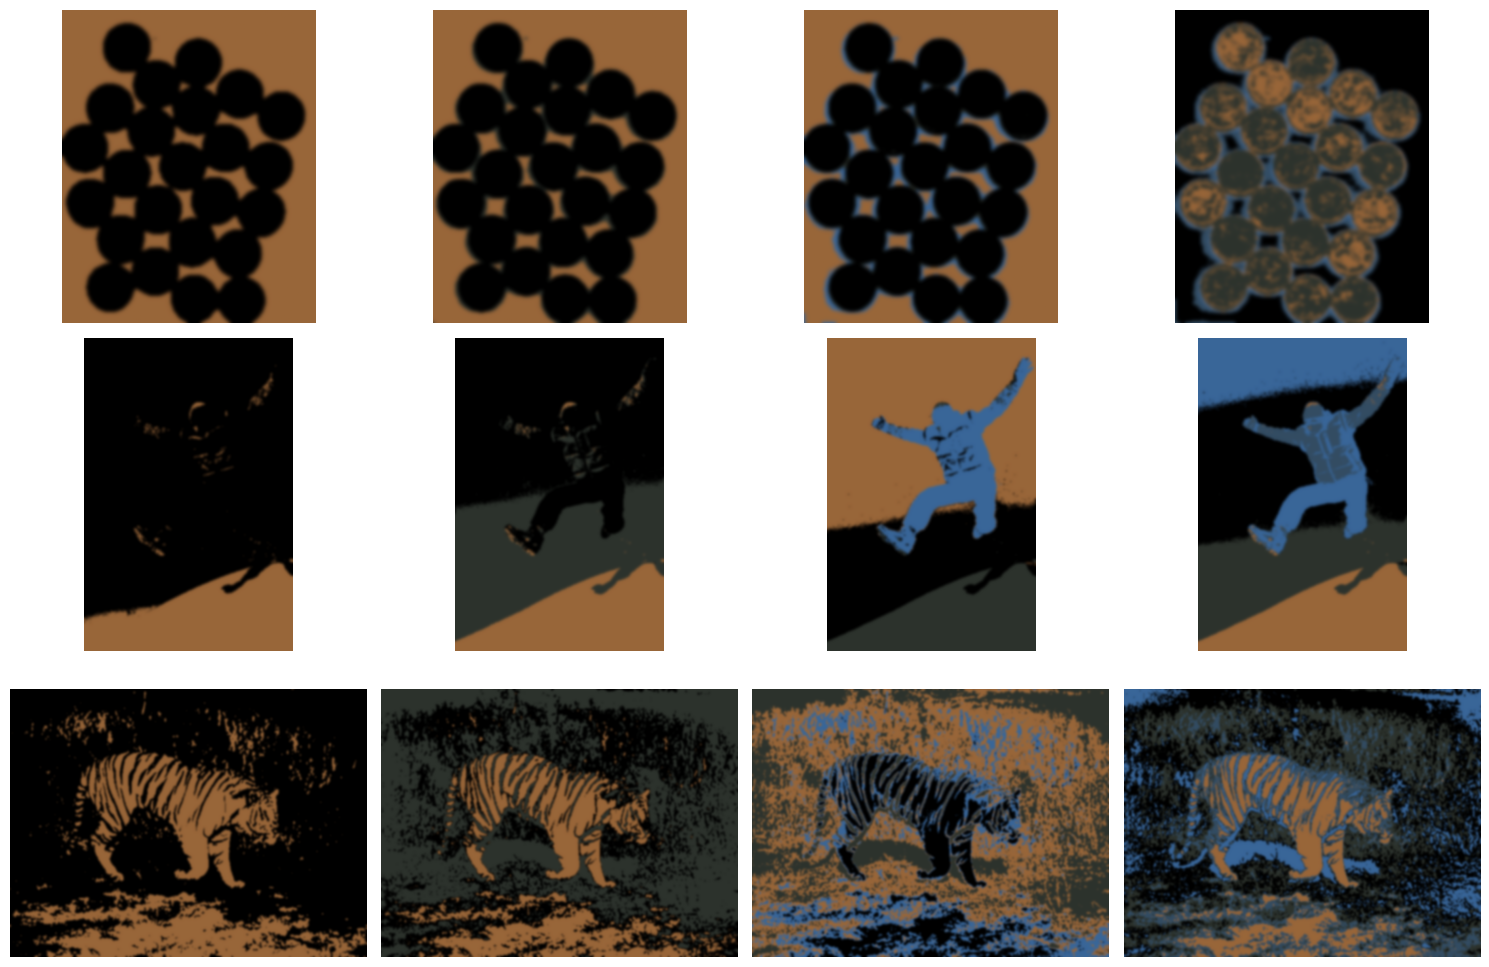

In [20]:
# Initialize subplots
fig, axes = plt.subplots(nrows=len(imgNames), ncols=len(segmentCounts), figsize=(15, 10))

# Loop through each image and segment count combination
for i, imgName in enumerate(imgNames):
    for j, SegCount in enumerate(segmentCounts):
        # Get the path of the segmented image corresponding to the last iteration
        last_iteration = iteration_counts[(imgName, SegCount)][-1]
        path = join('Output', str(SegCount) + '_segments', imgName, str(last_iteration) + '.png')
        
        # Load the segmented image
        segmented_img = mpimg.imread(path)
        
        axes[i, j].imshow(segmented_img)
        axes[i, j].axis('off')

plt.tight_layout()

plt.savefig('segmented_images.png')

plt.show()
